# Fermion to qubit transformations

In this tutorial you will learn more about fermion to qubit transformations, including how to apply those already implemented in openfermion, and try your hand at constructing your own!

1. Fermions and Qubits
    1. Fermionic states
    1. Fermionic operators and commutation relations
1. The Jordan-Wigner transform
    1. Jordan-Wigner transformation in OpenFermion
    1. Locality scaling under Jordan-Wigner
    1. Quadratic and quartic operator transforms
1. The Bravyi-Kitaev transform
    1. Occupation number and parity representations
    1. The transformation
    1. Locality scaling
1. The JKMN transform
    1. Majorana representation of Fermionic operators
    1. The ternary tree construction
    1. Locality scaling
1. Final notes and caveats
    1. Geometric locality: another point of view
    1. Ancillas to go "beyond optimal" scaling

# Fermions and Qubits

#### Fermionic states

As we saw during the lecture, states of a second-quantized fermionic system can be connected quite naturally to states of a qubit register.
In a fermionic system with $n$ modes (i.e. sites or orbitals), each mode can be either empty or filled, giving rise to $2^n$ basis states. These take the form $\vert f_0, f_1, ..., f_n\rangle$, with $f_j\in\{0 : \mathrm{empty}, 1 : \mathrm{filled}\}$.
The filling state of each mode can be represented by a qubit.
OpenFermion takes the following convention in representing the state of a Fermionic Mode:
- empty state : $\begin{pmatrix}1 \\ 0\end{pmatrix}$ &mdash; same representation as the $\vert0\rangle$ qubit state,
- filled state : $\begin{pmatrix}0 \\ 1\end{pmatrix}$ &mdash; same representation as the $\vert1\rangle$ qubit state.

The vector representation of multi-mode fermionic states is built from the single-mode states with kronecker products, the same way as for multi-qubit systems.

#### Fermionic operators and commutation relations

Under this convention, the **single-mode** creation and annihilation operators act like simple raising and lowering matrices on these vectors:

In [43]:
from openfermion import FermionOperator, get_sparse_operator

creation = FermionOperator('0^')
annihilation = FermionOperator('0')

print('creation operator:\n', get_sparse_operator(creation).A, '\n')
print('annihilation operator:\n', get_sparse_operator(annihilation).A)

creation operator:
 [[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]] 

annihilation operator:
 [[0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]]


Such $2 \times 2$ matrices can easily be constructed by linear combinations of Pauli matrices.
$$
   c^\dagger \to \frac{\sigma_x - i \sigma_y}{2} 
   \quad , \qquad 
   c \to \frac{\sigma_x + i \sigma_y}{2}
$$

Unfortunately, constructing the representation of fermionic operators in a **multi-mode** system is more complicated than taking a kronecker product of such matrices.
This is because fermionic operators acting on different modes **anticommute**, while qubit operators acting on different qubits **commute**.

**Exercise 1:** Construct the QubitOperators corresponding to the single-mode $c$ and $c^\dagger$ and verify their commutation relations. 

In [1]:
from openfermion import QubitOperator
def com(A, B):  return A*B - B*A
def acom(A, B): return A*B + B*A

c    = QubitOperator('X0', 0.5) + QubitOperator('Y0', 0.5j) 
cdag = QubitOperator('X0', 0.5) + QubitOperator('Y0', -0.5j) 

print('com  : ',  com(c, cdag))
print('acom : ', acom(c, cdag))

com  :  (1+0j) [Z0]
acom :  (1+0j) []


**Exercise 2:** Convince yourself that QubitOperators acting on different qubits commute, while fermionic creation/annihilation operators on different modes *anti*commute.

# The Jordan-WIgner transform

The Jordan-Wigner transformation is arguably the simplest method to map fermionic operators to qubit operators while conserving commutation relations.

To reconstruct the correct commutation relations, the Jordan-Wigner transformation attaches to each fermionic operator at site $k$ a sign $\{+, -\}$, depending on the **parity** of the number of fermions in the first $k-1$ modes: $P(k) = (-1)^{\sum_{j=0}^{k-1} f_j}$. 
A creation (or annihilation) operator $c^\dagger_j$ changing the state of a $f_j$, will also change the parity $P(k)$ for $k>j$. This changes the sign carried over by any operator on the mode $k$ applied **after** $c^\dagger_j$, making the overall sign depend on the order of operators.

For the separable basis states $\vert f_0\rangle \otimes \vert f_1\rangle \otimes ... \otimes  \vert f_n\rangle$ the action of the creation operator is defined as
$$
    c^\dagger_k \vert f_0\rangle \otimes ... \otimes \vert f_k \rangle \otimes ... \otimes  \vert f_n\rangle =
    (-1)^{\sum_{j=0}^{k-1} f_j} \vert f_0\rangle \otimes ... \otimes \left(c^\dagger_k \vert f_k \rangle\right) \otimes ... \otimes  \vert f_n\rangle,
$$
where the action of $\left(c^\dagger_k \vert f_k \rangle\right)$ is the one defined above for the single mode.
Defining the action on basis states is enough to describe an operator (extending to other states by linearity).

The parity $P(k)$ can be calculated by a string of Pauli Z operators $Z_0\,Z_1\,...\,Z_{k-1}$ (called Jordan-Wigner string), as each $Z_j$ takes the value $-1$ when a state is filled $\vert f_j=1 \rangle$ and $+1$ otherwise.
This brings us to the definition of the Jordan-Wigner transform:
\begin{equation}
    c^\dagger_k \to Z_0\,...\,Z_{k-1} \frac{X_k - i Y_k}{2} \\
    c_k         \to Z_0\,...\,Z_{k-1} \frac{X_k + i Y_k}{2} 
    \label{eq:JW} \tag{1}
\end{equation}


### Jordan-Wigner transformation in OpenFermion

Fermion to qubit transformations are core elements of OpenFermion. They can be found in the module `openfermion.transforms`. Let's have a look at the `jordan_wigner` function:

In [1]:
from openfermion.transforms import jordan_wigner
help(jordan_wigner)

Help on function jordan_wigner in module openfermion.transforms._jordan_wigner:

jordan_wigner(operator)
    Apply the Jordan-Wigner transform to a FermionOperator,
    InteractionOperator, or DiagonalCoulombHamiltonian to convert
    to a QubitOperator.
    
    Operators are mapped as follows:
    a_j^\dagger -> Z_0 .. Z_{j-1} (X_j - iY_j) / 2
    a_j -> Z_0 .. Z_{j-1} (X_j + iY_j) / 2
    
    Returns:
        transformed_operator: An instance of the QubitOperator class.
    
        The runtime of this method is exponential in the maximum locality
        of the original FermionOperator.
    
    Raises:
        TypeError: Operator must be a FermionOperator,
            DiagonalCoulombHamiltonian, or InteractionOperator.



**Exercise 3:** construct the the QubitOperators corresponding to fermionic creation and annihilation operators under Jordan-Wigner transform, and verify they satisfy fermionic commutation relations. (you can compare with exercise 3 of the "Introduction to OpenFermion" tutorial)

In [48]:
from openfermion import FermionOperator, normal_ordered
from itertools import combinations
from _jkmn import inline

n = 3
fops = []
for idx in range(n):
    fops.append( FermionOperator((idx, 0),) )
    fops.append( FermionOperator((idx, 1),) )

for A, B in combinations(fops, 2):
    print(f'acom({str(A):8}, {str(B):8}) =', normal_ordered(acom(A, B)))
    print('acom after JW transform  :', acom(jordan_wigner(A), jordan_wigner(B)))
    print()

acom(1.0 [0] , 1.0 [0^]) = 1.0 []
acom after JW transform  : (1+0j) []

acom(1.0 [0] , 1.0 [1] ) = 0
acom after JW transform  : 0

acom(1.0 [0] , 1.0 [1^]) = 0
acom after JW transform  : 0

acom(1.0 [0] , 1.0 [2] ) = 0
acom after JW transform  : 0

acom(1.0 [0] , 1.0 [2^]) = 0
acom after JW transform  : 0

acom(1.0 [0^], 1.0 [1] ) = 0
acom after JW transform  : 0

acom(1.0 [0^], 1.0 [1^]) = 0
acom after JW transform  : 0

acom(1.0 [0^], 1.0 [2] ) = 0
acom after JW transform  : 0

acom(1.0 [0^], 1.0 [2^]) = 0
acom after JW transform  : 0

acom(1.0 [1] , 1.0 [1^]) = 1.0 []
acom after JW transform  : (1+0j) []

acom(1.0 [1] , 1.0 [2] ) = 0
acom after JW transform  : 0

acom(1.0 [1] , 1.0 [2^]) = 0
acom after JW transform  : 0

acom(1.0 [1^], 1.0 [2] ) = 0
acom after JW transform  : 0

acom(1.0 [1^], 1.0 [2^]) = 0
acom after JW transform  : 0

acom(1.0 [2] , 1.0 [2^]) = 1.0 []
acom after JW transform  : (1+0j) []



### Locality scaling under Jordan-Wigner

We define **locality** (or many-body order) of an operator the maximum number of modes or of qubits on which the operator acts non-trivially at the same time. In openfermion we can access this value by the `many_body_order()` method of the FermionOperator and QubitOperator classes.
We say an operator is **k-local** if its locality is at most $k$.

The Jordan-Wigner maps a FermionOperator acting on a single mode (1-local) to a QubitOperator acting on many qubits. In fact, every $c_k$ acts nontrivially on the first $k$ qubits (k-local).

**Exercise 4:** compute the average locality of all Jordan-Wigner transformed single-qubit operators in a n-mode system. Verify that this result is what you would expect.

In [127]:
from openfermion import FermionOperator

print('N -> avg locality')
for N in range(2, 10):
    print(N, '->', 
          np.average(list(jordan_wigner(FermionOperator(str(i))).many_body_order() 
                          for i in range(N)))
         )

N -> avg locality
2 -> 1.5
3 -> 2.0
4 -> 2.5
5 -> 3.0
6 -> 3.5
7 -> 4.0
8 -> 4.5
9 -> 5.0


Wehat you just verified shows that Jordan-Wigner transform does not preserve locality. A generic $k-$local fermionic operator will be transformed into a qubit operator which locality depends on the system size. 
This is a general property of fermion to qubit transformations, and gives rise to one of the major challenges in simulating fermionic problems on a quantum computer.
When simulating the evolution of a system, this implies we will need to implement operations on a number of qubits that gets larger with increasing system size.

### Quadratic and quartic operator transforms 

Hamiltonians relevant for the electronic structure problem consist of terms that are quadratic (i.e. 2-local: site energies and hoppings) and quartic (i.e. 4-local: Coulomb interactions). These can all be written in normal-ordered form:
- $ c^\dagger_i c_j \quad \forall \, i, j $
- $ c^\dagger_i c^\dagger_j c_k c_l \quad \forall \, i>j; k>l $

**Exercise 5:** construct all quadratic particle-conserving operator terms for an $n$-mode fermionic system, transform them with Jordan-Wigner and calculate the average locality of the resulting QubitOperator. Do the same for quartic operators. Plot the results and infer the scaling of the average locality with the system size $n$.

In [131]:
def single_avg_loc(n):
    fops = (FermionOperator(f'{i}') for i in range(n)) # generator
    qops = (jordan_wigner(fop) for fop in fops) # generator
    localities = list(qop.many_body_order() for qop in qops)
    return np.average(localities)

def quadratic_avg_loc(n):
    fops = (FermionOperator(f'{i}^ {j}') for i in range(n) for j in range(n)) # generator
    qops = (jordan_wigner(fop) for fop in fops) # generator
    localities = list(qop.many_body_order() for qop in qops)
    return np.average(localities)

def quartic_avg_loc(n):
    fops = (FermionOperator(f'{i}^ {j}^ {k} {l}') 
            for i in range(n) for j in range(i) for k in range(n) for l in range(k)
           ) # generator
    qops = (jordan_wigner(fop) for fop in fops) # generator
    localities = list(qop.many_body_order() for qop in qops)
    return np.average(localities)

In [132]:
import matplotlib.pyplot as plt

In [133]:
n_list = np.arange(2, 20)

single_locs_jw = list(single_avg_loc(n) for n in n_list)
quadratic_locs_jw = list(quadratic_avg_loc(n) for n in n_list)
quartic_locs_jw = list(quartic_avg_loc(n) for n in n_list)

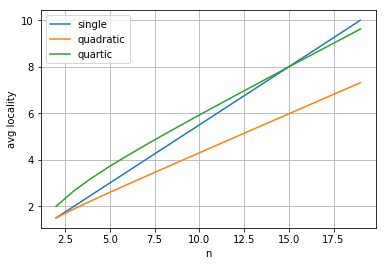

In [134]:
plt.plot(n_list, single_locs_jw, label='single')
plt.plot(n_list, quadratic_locs_jw, label='quadratic')
plt.plot(n_list, quartic_locs_jw, label='quartic')
plt.legend()
plt.ylabel('avg locality')
plt.xlabel('n')
plt.grid()
plt.show()

### Geometric locality under Jordan-Wigner

Another relevant concept in physics is **geometric locality** (not to be confused with k-locality, defined earlier!).
Most phyisical systems live in a $d$-dimensional space (with $d\leq3$), where particles interact mostly or only with neighboring ones. 
Typical examples of fermionic systems with geometrically local interactions are electrons in crystal lattices.
Geometrically-local systems can typically be represented on a lattice, with nearest-neighbor interactions  (or extensions thereof).

The Jordan-Wigner transformation lets us exploit geometric locality of lattices to our advantage. 
If the $Z$ operator Jordan-Wigner strings of two operators $c^\dagger_j$ and $c_k$ largely overlap, they will square and cancel in the quadratic operator $c^\dagger_j c_k$ (similar for quartic operators, where there are two couples of fermionic operators to consider).
In a lattice, only a specific set of $c^\dagger_j c_k$ are allowed: the ones for which $j$ and $k$ index neighboring sites.
Indexing sites following the geometric structure of the lattice, lets us reduce the many-body order of the resulting QubitOperators.

**Exercise 6:** 
Construct all hopping operators $c^\dagger_j c_{j\pm1}$ in a fermionic $d=1$ lattice (a chain) with $n$ sites. 
Verify that the many-body order of the Jordan-Wigner transformed operator is constant. 
Now reshuffle the indices by a random permutation $j\to\alpha(j)$ (hoppings will now be $c^\dagger_{\alpha(j)}, c_{\alpha(j\pm1)}$ and verify you recover the linear scaling of locality of the transormed operator with $n$.

In [151]:
from openfermion import FermionOperator, jordan_wigner

def avg_loc_jw_chain(n):
    hopping_fops = ([FermionOperator(f'{idx}^ {idx+1}')  for idx in range(n-1)] +
                    [FermionOperator(f'{idx} {idx+1}^')  for idx in range(n-1)] )
    hopping_qops = [jordan_wigner(fop) for fop in hopping_fops]
    localities = [qop.many_body_order() for qop in hopping_qops ]
    return np.average(localities)

print('N -> avg locality')
for n in range(2, 10):
    print(n, '->', avg_loc_jw_chain(n))

N -> avg locality
2 -> 2.0
3 -> 2.0
4 -> 2.0
5 -> 2.0
6 -> 2.0
7 -> 2.0
8 -> 2.0
9 -> 2.0


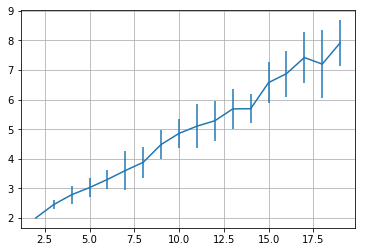

In [164]:
from numpy.random import permutation

def avg_loc_jw_chain(n):
    perm = permutation(n)
    hopping_fops = ([FermionOperator(f'{perm[idx]}^ {perm[idx+1]}')  for idx in range(n-1)] +
                    [FermionOperator(f'{perm[idx]} {perm[idx+1]}^')  for idx in range(n-1)] )
    hopping_qops = [jordan_wigner(fop) for fop in hopping_fops]
    localities = [qop.many_body_order() for qop in hopping_qops]
    return np.average(localities)

sample_number=20

n_list = np.arange(2, 20)
avgs = []
stds = []
for n in n_list:
    samples = [avg_loc_jw_chain(n) for _ in range(sample_number)]
    avgs.append(np.average(samples))
    stds.append(np.std(samples))

plt.errorbar(n_list, avgs, yerr=stds)
plt.grid()
plt.show()

**Exercise 7:** 
Use the function below to generate all quadratic operators in a nearest-neighbor square lattice of side length $L$. Compute the average locality of the transformed operator as a function of the system size $L^2$, how does it scale? Think of how can you intepret the result.

In [79]:
def square_lattice_quadratic(L):
    from openfermion.hamiltonians import fermi_hubbard
    return fermi_hubbard(x_dimension=L,
                         y_dimension=L,
                         tunneling = -1.0, # hoppings (quadratic)
                         coulomb = 0.0, # electrostatic interaction: change to 1.0 to get quartic terms
                         chemical_potential = -1.0, # on-site energy (quadratic)
                         periodic = False, # open boundary conditions
                         spinless = True # one fermion per site
                        ).get_operators() # returns a generator of all (quadratic) terms

def avg_loc_jw_square(L):
    fops = square_lattice_quadratic(L)
    qops = [jordan_wigner(fop) for fop in fops]
    localities = [qop.many_body_order() for qop in qops ]
    return np.average(localities)

print(' L |  n  | avg locality')
for L in range(1, 10):
    print(f'{L:2} |{L**2:^5}|', avg_loc_jw_square(L))

 L |  n  | avg locality
 1 |  1  | 1.0
 2 |  4  | 2.0
 3 |  9  | 2.4545454545454546
 4 | 16  | 2.875
 5 | 25  | 3.2857142857142856
 6 | 36  | 3.6923076923076925
 7 | 49  | 4.096774193548387
 8 | 64  | 4.5
 9 | 81  | 4.902439024390244


In [73]:
import matplotlib.pyplot as plt

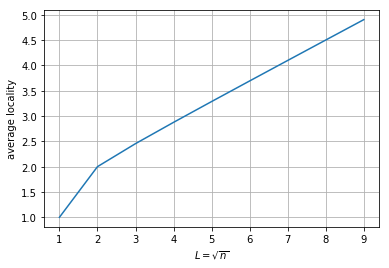

In [91]:
L_list = np.arange(1, 10)
loc_list = [avg_loc_jw_square(int(L)) for L in L_list]
plt.plot(L_list, loc_list)
plt.xlabel('$L = \sqrt{n}$')
plt.ylabel('average locality')
plt.grid()
plt.show()

# The Bravyi-Kitaev transform 

The qubit representation of fermionic operations is, in general, non-local.
This is because the action of any fermionic operator depends, through commutation relations, on all previously-applied operators. 
Generic operations on fermions at the opposite ends of a lattice still influence each other!
Nevertheless, using more complicated ways to encode fermionic states and to map fermionic operators to a qubit register, we can improve on the linear scaling of locality we found for Jordan-Wigner transformed operators, even in absence of a lattice structure.
The Bravyi-Kitaev transform was the first to obtain a logarithmic scaling with $n$ of the average locality of transformed single-fermion operators.

###  Occupation number and parity representations

To understand Bravyi-Kitaev transform, we have to realize that when we want to calculate the action of a fermionic operator $c^\dagger_k$ on a fermionic state, two things matter:
- $f_k$, the **occupation** state of the site $k$ (defining whether $c^\dagger_k$ can actually "succeed" in creating a fermion, or if it will "fail" sending the state to $0$)
- $P(k)$ the **parity** of the total number of fermions in sites $j<k$, to determine the sign $\{+, -\}$ that the operator carries, to take into account the (anti)commutation relations.
In Jordan-Wigner encoding, the occupation of the $k$-th site is stored in the $k$-th qubit (locally), while the parity $P(k)$ is stored non-locally in all sites $j:j<k$. This is the very origin of the Jordan-Wigner string, and of the linear scaling of the locality of transformed operators.
We say that Jordan-Wigner encodes the fermionic state to the qubit register in the **number representation**.

Dual to the Jordan-Wigner encoding is the **parity representation**, where each qubit $k$ stores the parity $P(k+1)$, and the occupation $f_k$ is calculated by multiplying the parities $P(k)$ and $P(k+1)$. The occupation state $f_k$ can be changed by the qubit operator $X_{k+1} \pm i Z_{k} Y_{k+1}$ (check this!). This way, parity $P(k)$ and occupation $f_k$ at site $k$ only depend on qubits $k-1$ and $k$. 
Unfortunately nothing is gained in terms of locality of transformed operators: changing the occupation state at site $k$ by $c^\dagger_k$ involves changing the parity $P(j)$ for all $j>k$ (and thus flipping all qubits $j: j<k$).

**Exercise 8:** based on the information on parity representation encoding given in the previous paragraph, write the parity-encoding transforms for $c^\dagger_k$ and $c_k$ (similarly to Eq.1).

**Solution:**
$$
    c^\dagger_k \to \frac{X_{k+1} + i Z_{k} Y_{k+1}}{2} X_{k+2} ... X_{n} \\
    c_k         \to \frac{X_{k+1} - i Z_{k} Y_{k+1}}{2} X_{k+2} ... X_{n} \\
$$

### The transformation

Bravyi-Kitaev transform uses a hybrid encoding, where each qubit $q_k$ stores some information about the parity/occupation of a number of sites, according to the following recursive algorithm:
- for $k=0$, $q_k = f_k$ (like in the number representation. This will be true for all even $k$, after recursion)
- for $k=2^m+1$, $q_k = P(k+1)$ (like in the parity representation)
- for $k=2^m+j$ with $j\leq2^m$: 
    - consider the subsystem consisting of only fermions $2^m < k < 2^m+1$, relabeling $k \to j$
    - recursively apply these encoding rules
    - finally undo the relabelling ($j->k$).
    
An in-depth explaination of the algorithm, taking a pedagogical approach, can be found in [arXiv:1208.5986](https://arxiv.org/pdf/1208.5986.pdf), from which we took inspiration in writing this tutorial. There you can find also the full (highly non trivial) definition of the Bravyi-Kitaev mapping of fermionic operators.

### Locality scaling

In this encoding information is stored systematically in recursive binary groupings of sites, which can be represented by a binary tree. The key feature of this is that both parity $P(k)$ and occupation number $f_k$ at site $k$ are related to the state of only $\log_2(n)$ qubits (i.e. the depth of the binary tree).
We'll try to retrieve this scaling for the average locality empirically, using the `bravyi_kitaev` function of the `openfermion.transforms` module.

In [231]:
from openfermion.transforms import bravyi_kitaev
help(bravyi_kitaev)

Help on function bravyi_kitaev in module openfermion.transforms._bravyi_kitaev:

bravyi_kitaev(operator, n_qubits=None)
    Apply the Bravyi-Kitaev transform.
    
    Implementation from arXiv:quant-ph/0003137 and
    "A New Data Structure for Cumulative Frequency Tables" by Peter M. Fenwick.
    
    Note that this implementation is equivalent to the one described in
    arXiv:1208.5986, and is different from the one described in
    arXiv:1701.07072. The one described in arXiv:1701.07072 is implemented
    in OpenFermion as `bravyi_kitaev_tree`.
    
    Args:
        operator (openfermion.ops.FermionOperator):
            A FermionOperator to transform.
        n_qubits (int|None):
            Can force the number of qubits in the resulting operator above the
            number that appear in the input operator.
    
    Returns:
        transformed_operator: An instance of the QubitOperator class.
    
    Raises:
        ValueError: Invalid number of qubits specified.



Note that the Bravyi-Kitaev transform **needs** to know the total number of modes (or of qubits) in the system that is being transformed. Make sure to specify n_qubits when you use the `bravyi_kitaev` function.
e.g. the same operator $c_0$, as part of a $n$ modes system, looks different for different $n$:

In [232]:
n = 4 # Explore how this changes with n!
print(f'Example: in a {n}-modes system FermionOperators are mapped according to:')
for i in range(n):
    print(f'{i}  ->', str(bravyi_kitaev(FermionOperator(f'{i}'), n_qubits=n)).replace('\n', ' '))
    print(f'{i}^ ->', str(bravyi_kitaev(FermionOperator(f'{i}^'), n_qubits=n)).replace('\n', ' '))

Example: in a 4-modes system FermionOperators are mapped according to:
0  -> 0.5 [X0 X1 X3] + 0.5j [Y0 X1 X3]
0^ -> 0.5 [X0 X1 X3] + -0.5j [Y0 X1 X3]
1  -> 0.5 [Z0 X1 X3] + 0.5j [Y1 X3]
1^ -> 0.5 [Z0 X1 X3] + -0.5j [Y1 X3]
2  -> 0.5 [Z1 X2 X3] + 0.5j [Z1 Y2 X3]
2^ -> 0.5 [Z1 X2 X3] + -0.5j [Z1 Y2 X3]
3  -> 0.5 [Z1 Z2 X3] + 0.5j [Y3]
3^ -> 0.5 [Z1 Z2 X3] + -0.5j [Y3]


**Exercise 9:** Repeat the study did in exercises 4 and 5, this time using the Bravyi-Kitaev transform. Plot results in a log-lin graph, and verify the $\log_2(n)$ scaling of the average locality for transformed single, quadratic and quartic fermionic operators.

In [233]:
def single_avg_loc(n):
    fops = (FermionOperator(f'{i}') for i in range(n)) # generator
    qops = (bravyi_kitaev(fop, n) for fop in fops) # generator
    localities = list(qop.many_body_order() for qop in qops)
    return np.average(localities)

def quadratic_avg_loc(n):
    fops = (FermionOperator(f'{i}^ {j}') for i in range(n) for j in range(n)) # generator
    qops = (bravyi_kitaev(fop, n) for fop in fops) # generator
    localities = list(qop.many_body_order() for qop in qops)
    return np.average(localities)

def quartic_avg_loc(n):
    fops = (FermionOperator(f'{i}^ {j}^ {k} {l}') 
            for i in range(n) for j in range(i) for k in range(n) for l in range(k)
           ) # generator
    qops = (bravyi_kitaev(fop, n) for fop in fops) # generator
    localities = list(qop.many_body_order() for qop in qops)
    return np.average(localities)

In [234]:
import matplotlib.pyplot as plt

In [240]:
n_list = np.arange(2, 20)
single_locs_bk = list(single_avg_loc(n) for n in n_list)
quadratic_locs_bk = list(quadratic_avg_loc(n) for n in n_list)
quartic_locs_bk = list(quartic_avg_loc(n) for n in n_list)

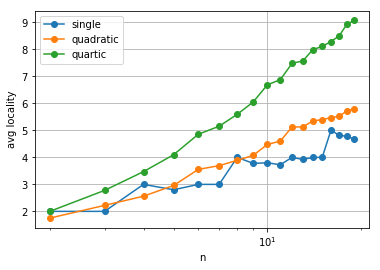

In [241]:
plt.plot(n_list, single_locs_bk, 'o-', label='single')
plt.plot(n_list, quadratic_locs_bk, 'o-', label='quadratic')
plt.plot(n_list, quartic_locs_bk, 'o-', label='quartic')
plt.legend()
plt.ylabel('avg locality')
plt.xlabel('n')
plt.xscale('log')
plt.grid()
plt.show()

The Bravyi-Kitaev transform restructures the geometry of the system to achieve logarithmic locality for a generic transformed operator.
In doing so, it loses the advantage that Jordan-Wigner transform could get in geometrically-local systems.

**Exercise 10:** Repeat the analysis for $d=1$ and $d=2$ lattices from exercises 6 and 7, using the Bravyi-Kitaev transform. Find the scaling of the average locality with $n$, compare it with results from exercise 9 and argue wether geometric locality gives a gain in this case, and how it compares to the advantage gained in the Jordan-Wigner case.

In [238]:
from openfermion import FermionOperator, jordan_wigner
from itertools import combinations

def avg_loc_bk_generic(n):
    hopping_fops = ([FermionOperator(f'{idx1}^ {idx2}')  for idx1, idx2 in combinations(range(n),2)]+
                    [FermionOperator(f'{idx2}^ {idx1}')  for idx1, idx2 in combinations(range(n),2)])
    hopping_qops = [bravyi_kitaev(fop, n) for fop in hopping_fops]
    localities = [qop.many_body_order() for qop in hopping_qops ]
    return np.average(localities)

def avg_loc_bk_chain(n):
    hopping_fops = ([FermionOperator(f'{idx}^ {idx+1}')  for idx in range(n-1)] +
                    [FermionOperator(f'{idx} {idx+1}^')  for idx in range(n-1)] )
    hopping_qops = [bravyi_kitaev(fop, n) for fop in hopping_fops]
    localities = [qop.many_body_order() for qop in hopping_qops ]
    return np.average(localities)

def avg_loc_bk_square(L):
    fops = square_lattice_quadratic(L)
    qops = [bravyi_kitaev(fop, L**2) for fop in fops]
    localities = [qop.many_body_order() for qop in qops ]
    return np.average(localities)

n_list = np.arange(2, 50)
L_list = np.arange(1, 8)
generic_locs_bk = [avg_loc_bk_generic(n) for n in n_list]
chain_locs_bk = [avg_loc_bk_chain(n) for n in n_list]
square_locs_bk = [avg_loc_bk_square(int(L)) for L in L_list]

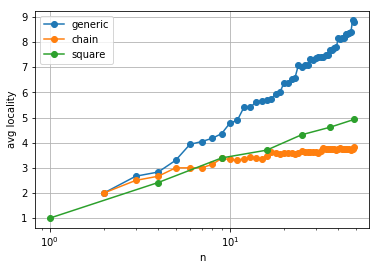

In [239]:
plt.plot(n_list, generic_locs_bk, 'o-', label = 'generic')
plt.plot(n_list, chain_locs_bk, 'o-', label = 'chain')
plt.plot(L_list**2, square_locs_bk, 'o-', label = 'square')
plt.legend()
plt.ylabel('avg locality')
plt.xlabel('n')
plt.xscale('log')
plt.grid()
plt.show()

# the JKMN transform 

The research on Fermion to Qubit mappings is still active. One of the most recent developments is dated Oct 2019 ([arXiv:1910.10746](https://arxiv.org/abs/1910.10746)).
In this paper, Zhang Jiang and collaborators propose an elegant method based on ternary trees to achieve average locality of transformed single fermionic operators to $\lceil{\log_3(n)}\rceil$ for a $n$-mode fermionic system.
The authors also prove this method to be *optimal*: no general fermion to qubit mapping using $n$ qubits can do better than this.

It is beyond the scope of this tutorial to explain the whole transform, but we give some concepts that can be useful if one wants to delve deeper into it.


### Majorana representation of Fermionic operators

To perform the JKMN transform we first have to rewrite the fermionic operators in term of **Majorana operators**, defined as
$$
    \gamma_{2j} = c^\dagger_j + c_j,\\
    \gamma_{2j+1} = i( c^\dagger_j - c_j ).
$$
These operators behave much like generalizations of Pauli operators: they are Hermitian and unitary, thus squaring to the identity $\gamma_j^2=\mathbb{1}$, and they all anticommute with each other ($\{\gamma_j, \gamma_k\} = 2\delta_{j,k}$).
For a single-mode system, their matrix representation also looks like Pauli matrices (note that the last matrix is obtained by the product of all the previous ones):

In [38]:
from openfermion import get_sparse_operator, FermionOperator

gamma_0 = FermionOperator('0^', 1) + FermionOperator('0', 1)
gamma_1 = FermionOperator('0^', 1j) + FermionOperator('0', -1j)

print('gamma_0  = [0^] + [0]')
print(get_sparse_operator(gamma_0).A, '\n(same form as Pauli X)\n')
print('gamma_1 = 1j [0^] - 1j [0]')
print(get_sparse_operator(gamma_1).A, '\n(same form as Pauli Y)\n')
print('gamma_0 * gamma_1 = 2 [0^0] + 1 []')
print(get_sparse_operator(gamma_0 * gamma_1).A, '\n(same form as Pauli Z)\n')      

gamma_0  = [0^] + [0]
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]] 
(same form as Pauli X)

gamma_1 = 1j [0^] - 1j [0]
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]] 
(same form as Pauli Y)

gamma_0 * gamma_1 = 2 [0^0] + 1 []
[[0.+1.j 0.+0.j]
 [0.+0.j 0.-1.j]] 
(same form as Pauli Z)



An operator in an $n$-mode fermionic system can be rewritten by choosing among $2n$ Majorana operators (sometimes also called Majorana modes).

*Sidenote*: all transformations can be defined in terms of Majorana operators (as they're just a re-writing of fermionic operators). For JKMN this is specially useful.

### The ternary tree construction

Let's suppose that the number of fermionic modes in our system is $n = (3^m-1)/2$ (the extension to a generic $n$ is technical but conceptually simple).
The number of Majorana modes will then be $3^m-1$.
Let's now construct a **ternary tree** like in Figure 1 of the [JKMN paper](https://arxiv.org/abs/1910.10746):
we start with one root node from which 3 branches spring. At the end of every branch a new node springs 3 more branches. Repeating the operation $m$ times we obtain a tree with $3^m$ terminal nodes (or **leaf nodes**).
To each leaf node but the last one we assign one of the Majorana operators $\gamma_j$.
To each branching node (i.e. non-terminal node) we associate a qubit $Q_i$ (exercise: convince yourself that we need exactly $n$ qubits).
To each branch we associate one of the three pauli operators acting on the qubit on the node from which the branch springs $\{X_i, Y_i, Z_i\}$.
Each $\gamma_j$ will be mapped to a string of Pauli operators corresponding to the branches on the path that connect the leaf $\gamma_j$ to the root of the tree.

Mappings of $\gamma_j$ and $\gamma_{j'}$ will differ by a single different Pauli matrix on the same qubit, at the node where the paths join (plus a bunch of identities on qubits not touched by the paths.
For this reason, all transformed $\gamma_j$ will anticommute.
Also, as the number of branches on the path from any leaf to the root is $m = \log_3(2n+1)$, every majorana operator will be mapped to a $m$-local qubit operator.

### Locality scaling

The code for JKMN is not yet in openfermion, but we coded it for the tutorial and for our research. We are planning to add it to openfermion in the near future.
The code is in the module file `_jkmn.py`, which you should have downloaded from the course website. Run `import _jkmn` and `help(_jkmn)` to see the content of the module.
The function `jkmn` from this module is homologue to the `bravyi_kitaev` function of `openfermion.transforms` and requires the number of modes to be specified.

**Exercise 11:** The code below prints the `FermionOperator` objects for each of the 8 Majorana $\gamma_j$ in a $n=4$ fermionic modes system. Use JKMN to map them to QubitOperators and check the mapped operators against the tree in Figure 1 of the [JKMN paper](https://arxiv.org/abs/1910.10746).

In [225]:
from _jkmn import majorana_to_fermion, inline, jkmn
from openfermion import MajoranaOperator

n = 4
print(f'Maj |      Fermion op      |    JKMN-mapped Qubit op')
for maj_idx in range(2*n):
    fop = majorana_to_fermion(MajoranaOperator((maj_idx,)))
    qop = jkmn(fop, n)
    print(f'{maj_idx:^3} | {inline(fop):^20} | {inline(qop):^25}')


Maj |      Fermion op      |    JKMN-mapped Qubit op
 0  |  1.0 [0] + 1.0 [0^]  |        1.0 [X0 X1]       
 1  |   1j [0] - 1j [0^]   |      (1+0j) [X0 Y1]      
 2  |  1.0 [1] + 1.0 [1^]  |        1.0 [X0 Z1]       
 3  |   1j [1] - 1j [1^]   |      (1+0j) [Y0 X2]      
 4  |  1.0 [2] + 1.0 [2^]  |        1.0 [Y0 Y2]       
 5  |   1j [2] - 1j [2^]   |      (1+0j) [Y0 Z2]      
 6  |  1.0 [3] + 1.0 [3^]  |        1.0 [Z0 X3]       
 7  |   1j [3] - 1j [3^]   |      (1+0j) [Z0 Y3]      


**Exercise 12:** Use the `jkmn` function to perform the same study on average locality versus system size you performed for the Jordan-Wigner and Bravyi-Kitaev transforms. Do this for single fermionic operators, for quadratic and for quartic. 
For each, plot results of the three transforms together (choose the preferred plotting scale).

In [249]:
def single_avg_loc(n):
    fops = (FermionOperator(f'{i}') for i in range(n)) # generator
    qops = (jkmn(fop, n) for fop in fops) # generator
    localities = list(qop.many_body_order() for qop in qops)
    return np.average(localities)

def quadratic_avg_loc(n):
    fops = (FermionOperator(f'{i}^ {j}') for i in range(n) for j in range(n)) # generator
    qops = (jkmn(fop, n) for fop in fops) # generator
    localities = list(qop.many_body_order() for qop in qops)
    return np.average(localities)

def quartic_avg_loc(n):
    fops = (FermionOperator(f'{i}^ {j}^ {k} {l}') 
            for i in range(n) for j in range(i) for k in range(n) for l in range(k)
           ) # generator
    qops = (jkmn(fop, n) for fop in fops) # generator
    localities = list(qop.many_body_order() for qop in qops)
    return np.average(localities)

In [250]:
import matplotlib.pyplot as plt

In [251]:
n_list = np.arange(2, 20)
single_locs_jkmn = list(single_avg_loc(n) for n in n_list)
quadratic_locs_jkmn = list(quadratic_avg_loc(n) for n in n_list)
quartic_locs_jkmn = list(quartic_avg_loc(n) for n in n_list)

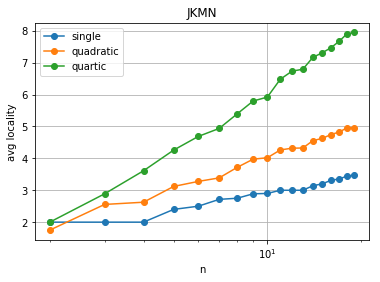

In [252]:
plt.title('JKMN')
plt.plot(n_list, single_locs_jkmn, 'o-', label='single')
plt.plot(n_list, quadratic_locs_jkmn, 'o-', label='quadratic')
plt.plot(n_list, quartic_locs_jkmn, 'o-', label='quartic')
plt.legend()
plt.ylabel('avg locality')
plt.xlabel('n')
plt.xscale('log')
plt.grid()
plt.show()

#### summary of localities for singles 

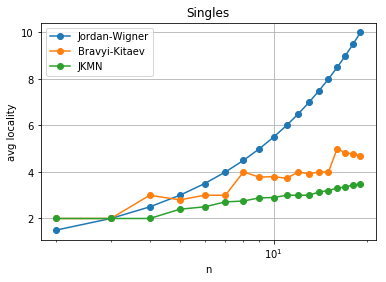

In [253]:
plt.title('Singles')
plt.plot(n_list, single_locs_jw, 'o-', label='Jordan-Wigner')
plt.plot(n_list, single_locs_bk, 'o-', label='Bravyi-Kitaev')
plt.plot(n_list, single_locs_jkmn, 'o-', label='JKMN')
plt.legend()
plt.ylabel('avg locality')
plt.xlabel('n')
plt.xscale('log')
plt.grid()
plt.show()

# Final notes and caveats

#### Geometric locality: another point of view

We saw that Jordan-Wigner transform preserves takes into account geometric locality to some degree, while Bravyi-Kitaev and JKMN don't. 
This is useful when studying systems that can be mapped to a local lattice.
Most phyisical systems have built-in geometric locality at some scale: at a deep level all physical sytems are local because of relativity!
Unfortunately this scale is sometimes larger than what we can ever expect to simulate on a quantum computer.

In chemistry, for example, Hamiltonians constructed using molecular orbitals (which often extend over many atoms) as modes are often not geometrically local at all.
Finding efficient ways to construct molecular Hamiltonians that use localised fermionic modes, to retain some sort of geometric locality, is an active research field (with applications beyond efficiency of fermion to qubit mappings).

Furthermore, most quantum devices that can be used to actually implement quantum algorithms are themselves geometrically local. 
Qubits are arranged in some lattice structure, typically on a plane or on a line, and can only interact with a subset of neighboring qubits.
(Examples are superconducting qubits, spin qubits and most topological qubit models. Notable exceptions are ion-based devices, which show all-to-all interactions).
Simulating a geometrically local fermionic system on a geometrically local quantum processor might quickly become very hard because non-local operations might be needed.
In this case, Jordan-Wigner might be much better than the seemingly more optimized JKMN!

#### Ancillas to go "beyond optimal" scaling

Even though it is proven that no transform that maps the whole fermionic $n$-mode Hilbert space to $n$ qubits can show better locality scaling than BKSF, better locality can be achieved adding ancilla qubits.
Bravyi-Kitaev superfast transform  (BKSF, not to be confused with Bravyi-Kitaev!) does exactly this to achieve *constant* locality at a cost of introducing a qubit for each interaction.
These kind of transforms tend to be less general (BKSF can *only* map number-conserving quadratic and quartic operators), allowing to exploit specific properties of the problem.